In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from ISLP.models import (ModelSpec as MS, 
                         summarize)
import statsmodels.api as sm

## Applying linear regression on data scraped from Funda

Use the [funda-scraper](https://pypi.org/project/funda-scraper/) to scrape data from funda. In this notebook, we read the Funda data from a pickle file

In [2]:
houses_df = pd.read_pickle('houses_df.pkl')
houses_df.drop(columns=['house_id', 'address', 'descrip'], inplace=True)

### Inspect the data

In [3]:
houses_df.head()

,city,house_type,building_type,price,price_m2,room,bedroom,bathroom,living_area,energy_label,zip,year_built,house_age,date_list,ym_list,year_list
0,amsterdam,appartement,Bestaande bouw,400000,8000.0,2,1,1,50,D,1056,1930,93,2023-08-29,2023-08-01,2023
1,amsterdam,appartement,Bestaande bouw,450000,6923.1,4,3,1,65,C,1091,1960,63,2023-08-29,2023-08-01,2023
2,amsterdam,appartement,Bestaande bouw,300000,4545.5,3,2,1,66,B,1106,1983,40,2023-08-28,2023-08-01,2023
3,amsterdam,appartement,Bestaande bouw,625000,6377.6,3,2,1,98,A,1061,2013,10,2023-08-28,2023-08-01,2023
4,amsterdam,appartement,Bestaande bouw,485000,4754.9,4,3,1,102,D,1024,1967,56,2023-08-29,2023-08-01,2023


### Apply simple linear regression to predict price from living_area

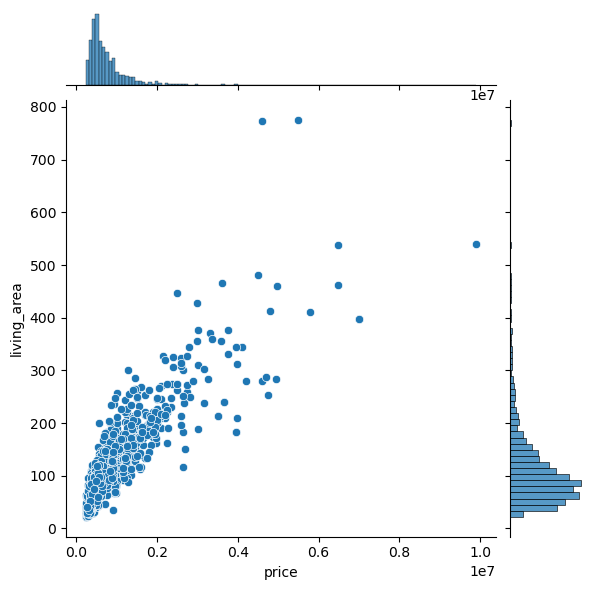

In [4]:
sns.jointplot(x='price', y='living_area', data=houses_df, kind='scatter')

#### Deciding that we don't want to buy a house more expensive than 1,000,0000

Early findings:
- Price most dense around €500,000
- Living area most dense around 80 $m^2$
- Relationship seems linear, however the variance increases for prices/living area

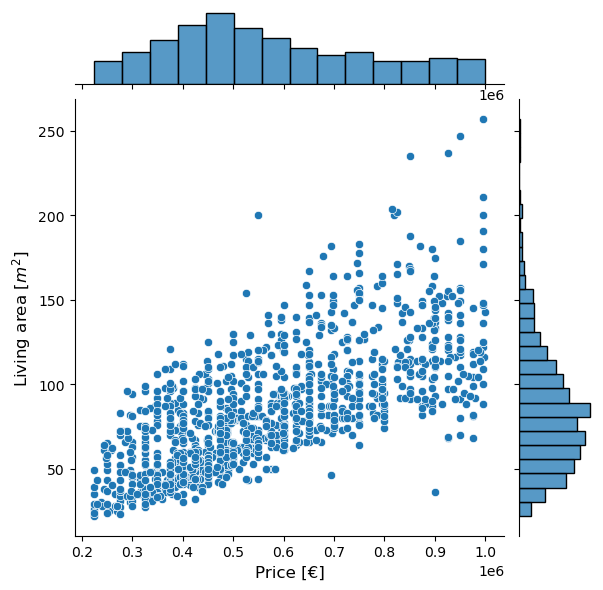

In [5]:
mil_df = houses_df[houses_df.price<1000000]
jplot = sns.jointplot(x='price', y='living_area', data=mil_df, kind='scatter')
jplot.set_axis_labels('Price [€]', 'Living area [$m^2$]', fontsize=12)

#### Split the data in a train and test set

#### More advanced statistical insights using the statmodels library

For now, not splitting up in test and training data

In [6]:
# X = mil_df['living_area'].values.reshape(-1,1)
# y = mil_df['price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

First, we create a dataframe we can use to fit our linear model

In [8]:
design = MS(['living_area'])
Xsm = design.fit_transform(mil_df)
Xsm.head()

,intercept,living_area
0,1.0,50
1,1.0,65
2,1.0,66
3,1.0,98
4,1.0,102


Then we fit our model and print a summary of the results

In [9]:
ysm = mil_df['price']
model = sm.OLS(ysm, Xsm)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,236100.0000,10300.00,22.894,0.0
living_area,3973.9506,112.88,35.205,0.0


Result analysis

- The fitted line intersects the y-axis at 236100 Euro
- Per m2, the price of a house will increase with ~3938 Euro
- The standard error roughly defines how far off the estimates of the coeficients $(\hat{\beta}_0, \hat{\beta}_1)$ are from the actual coefficients $(\beta_0, \beta_1)$. The standard error for the mean of a population:
$$Var(\hat{\mu}) = SE(\hat{\mu})^2 = \frac{\sigma^2}{n}$$
- E.g. we can say with 95% confidence that the true value for $\beta_1$ will be between:
$$\hat{\beta}_1 \pm 2*SE(\hat{\beta}_1) \approx (3748,4200) $$  
- Using the standard error, we can perform hypothesis tests:
    - Null hypothesis, $H_0 : \beta_1 = 0$, There is no relationship between X and Y
    - Alternative hypothesis: $H_a : \beta_1 \neq 0$, There is some relationship between X and Y
    - We need to determine whether our estimate of $\beta_1$ is sufficiently far from zero, so we can say confidently it is non-zero, which we can do with the *t-statistic*:
    $$t = \frac{\hat\beta_1}{SE(\hat\beta_1)} = \frac{\text{Our estimate of } \hat\beta}{\text{How far } \hat\beta \text{ is likely off}} = \text{number of standard deviations }\hat\beta_1 \text{ is away from 0}$$
    - The probability of observing any number equal to *t* or larger in absolute value is called the *p-value*, e.g. there is a *p-value*% chance of observing a substantial relation between the predictor and the response due to chance, e.g. with small *p-values*, we can reject the null hypothesis!




#### Plotting the fit

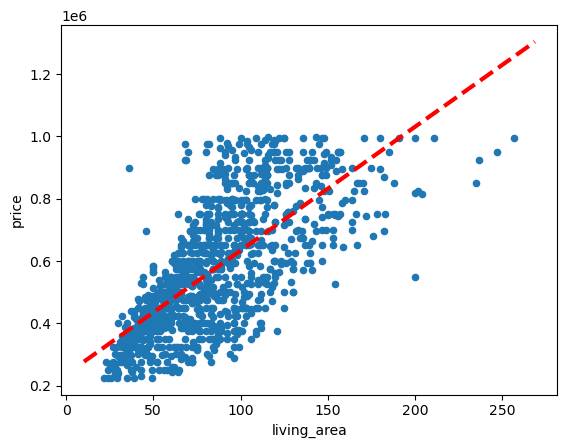

In [10]:
def abline(ax, b, m, *args , **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

ax = mil_df.plot.scatter('living_area', 'price')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

##### Assessing the goodness of the fit using $R^2$

We find that $R^2$ is 0.505, which means: 50.5% of the variability in the response is explained/removed by performing the regression

Further explanation on $R^2$:

$$ R^2 = \frac{TSS-RSS}{TSS} = 1 - \frac{RSS}{TSS} $$

Where $TSS$ is the variance around the mean (simplest estimate we can make) and $RSS$ is the *residual sum of squares*

$$ \sum (y_i-\bar{y})^2 $$
$$ \sum_{i=1}^n (y_i -\hat{y}_i)^2$$

The Residual Standard Error (RSE), is an estimate of the standard deviation of the prediction error $\epsilon$, i.e. the average amount that the response will deviate from the true regression line
$$RSE = \sqrt{\frac{1}{n-2}RSS}$$
The F-statistic is a way to determine wheter $R^2$ is statistically significant

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     1239.
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          8.14e-188
Time:                        19:27:16   Log-Likelihood:                -16157.
No. Observations:                1219   AIC:                         3.232e+04
Df Residuals:                    1217   BIC:                         3.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    2.361e+05   1.03e+04     22.894      0.000    2.16e+05    2.56e+05
living_area  3973.9506    112.880     35.205      0.000    3752.489    4195.412
==============================================================================
Omnibus:                       22.624   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.925
Skew:                           0.306   Prob(JB):                     6.38e-06
Kurtosis:                       3.310   Cond. No.                         238.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Prediciting the price of a house with various living_area

In [12]:
new_df = pd.DataFrame({'living_area': [50, 100, 150]})
new_X = design.transform(new_df)
new_X

,intercept,living_area
0,1.0,50
1,1.0,100
2,1.0,150


In [13]:
new_predictions = results.get_prediction(new_X)
new_predictions.predicted_mean

array([434838.08305015, 633535.61461701, 832233.14618386])

And the related confidence intervals are:

In [14]:
new_predictions.conf_int(alpha=0.05)

array([[423963.20889811, 445712.95720219],
       [625036.25165626, 642034.97757776],
       [815757.65163355, 848708.64073418]])

I believe the confidence interval is very narrow, wrt the residual plot, how is that possible? --> Residuals are not constant over the fitted values
Next step: investigate potential issues with the data by checking residuals etc.

#### Residual analysis (maybe remove and only address multiple part in to keep things short?)

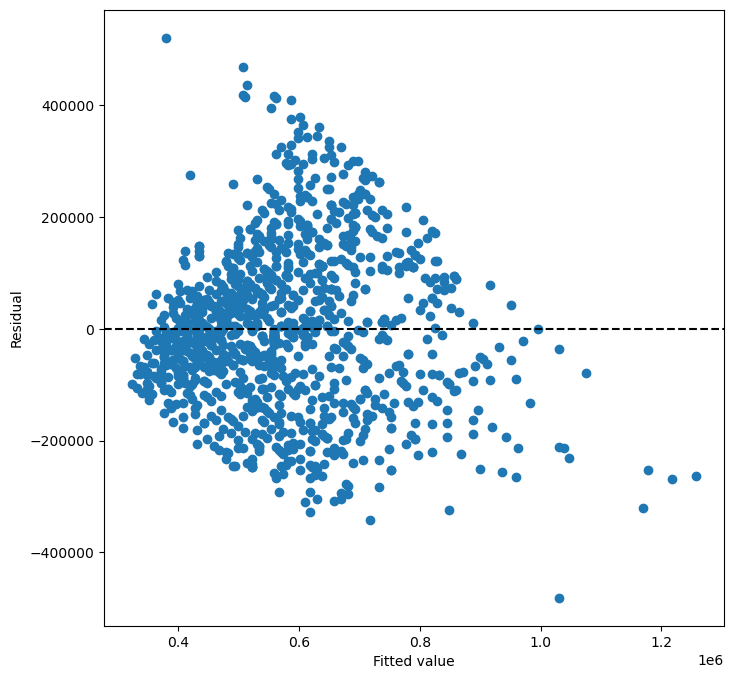

In [15]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

Question to self: what is the difference between a confidence interval and a prediction interval?

### Draft cells below

#### Apply simple linear regression using sklearn

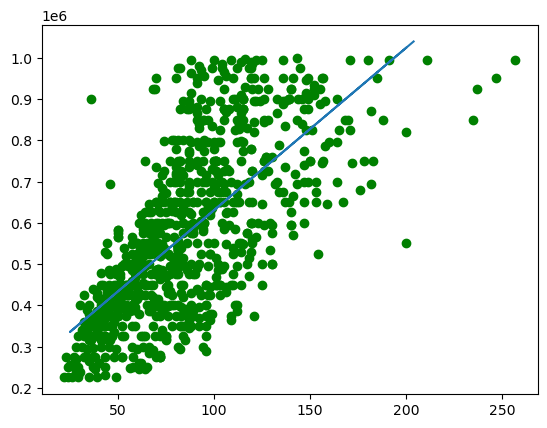

In [28]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X, y)
reg.coef_
reg.intercept_
print('R^2: ', reg.score(X_test, y_test), '\n', 'Slope: ', reg.coef_, '\n', 'Intercept: ', reg.intercept_) 

fig, ax = plt.subplots()
ax.plot(X_test, reg.predict(X_test), label='data')
ax.scatter(X_train, y_train, label='data', c='g')

Text(0.5, 1.0, 'House Price vs Living Area, colored by Listing Date')

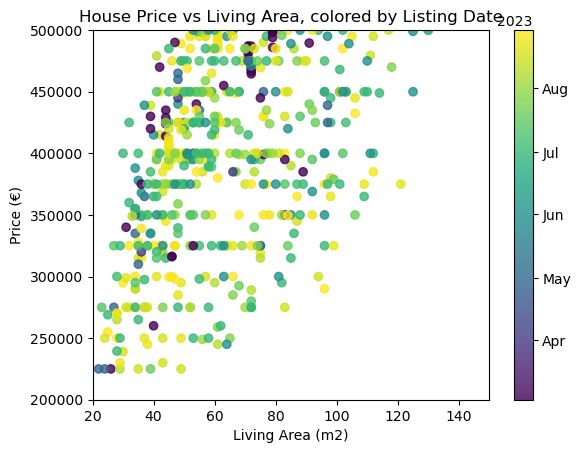

In [22]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
# sns.scatterplot(data=houses_df, x='living_area', y='price', hue = 'date_list',  palette='RdBu', ax = ax)

plt.scatter(houses_df['living_area'], houses_df['price'], c=mdates.date2num(houses_df['date_list']), cmap='viridis', alpha=0.8)
cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
ax.set_ylim(200000, 500000)
ax.set_xlim(20, 150)
ax.set_ylabel('Price (€)')
ax.set_xlabel('Living Area (m2)')
ax.set_title('House Price vs Living Area, colored by Listing Date')


<AxesSubplot: >

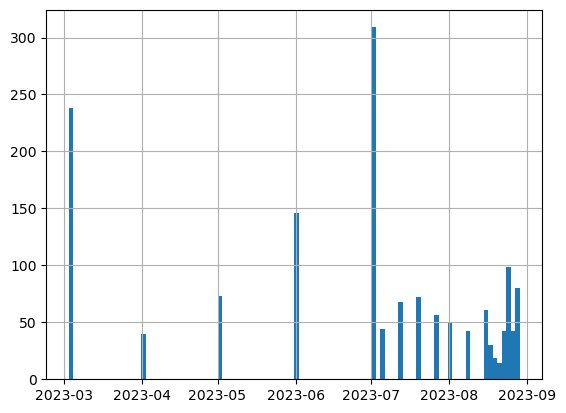

In [7]:
houses_df.date_list.hist(bins = 100)